#Universidad Autonoma de Aguascalientes

- ### Departamento: Ciencias de la computacion
- ### Carrera: Ingenieria en Computacion Inteligente
- ### Curso: Metaheuristicas I
- ### Maestro: Dr Francisco Javier Luna Rosas
- ### Alumnos: Jose Carlos Macias Macias, Sebastían Herrera Murillo, Guillermo Gonzales Lara, Luis Angel Flores Escobedo
- ### Fecha: 02/10/2024

# Examen 2
El alumno deberá analizar e implementar el método Optimización por Enjambre de Particulas
(PSO) para la Planificación de Carga de 100000 Criticas de Cine. El alumno deberá tomar
como base el articulo denominado: Observations on Using Genetic Algorithms for Dynamic
Load-Balancing.pdf.
La planificación deberá **mostrar una tabla y una gráfica en donde se compara el tiempo
secuencial vs el tiempo paralelo** (utilizando **n** procesadores homogéneos para: 10000, 20000,
30000, 40000, 50000, 60000, 70000, 80000, 90000 y 100000 criticas de cine)
La planificación deberá considerar el tiempo de ejecución real que tarda el procesador en
realizar el procesamiento de las críticas de cine.

### Importamos Librerias

In [19]:
import multiprocessing
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
# Descargar stopwords si no están ya descargadas
nltk.download('stopwords')

# Definir stopwords en inglés
stop_words = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(max_df=0.95)

[nltk_data] Downloading package stopwords to /home/maru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Analisis
Tenemos que analizar cuanto tarda el procesamiento de 10000 palabras mediante la limpieza de texto y procesamiento de TD-IDF Vectorizer.

Vamos a duplicar los resultados del CSV para tener 10000 resultados.

In [13]:
preCriticas = pd.read_csv("movie_data.csv", usecols=['review'])
criticas = pd.concat([preCriticas, preCriticas])

print(criticas.head())
print(criticas.count())

                                              review
0  In 1974, the teenager Martha Moxley (Maggie Gr...
1  OK... so... I really like Kris Kristofferson a...
2  ***SPOILER*** Do not read this, if you think a...
3  hi for all the people who have seen this wonde...
4  I recently bought the DVD, forgetting just how...
review    100000
dtype: int64


### Procesamiento
Esta función será la responsable de transformar nuestro texto a vectores.

In [14]:
def procesamiento(corpus):
    import re
    # print(corpus.head())
    def limpiarTexto(texto):
        # 1. Eliminar etiquetas HTML
        texto = re.sub(r'<.*?>', '', texto)
        # 2. Convertir todo a minúsculas
        texto = texto.lower()
        # 3. Quitamos los caracteres no alfanumericos
        texto = re.sub(r'[^a-z0-9\s]', '', texto)
        # 4. Eliminar stopwords
        texto = ' '.join([word for word in texto.split() if word not in stop_words])
        return texto

    corpus.loc[:, 'review'] = corpus['review'].apply(limpiarTexto)
    corpus_procesado = vectorizer.fit_transform(corpus['review'])

### Usando solamente 10000 criticas:

In [23]:
subset = criticas.head(10000)

inicio = time.time()
procesamiento(subset)
fin = time.time()
print("Tiempo de procesamiento: ", fin - inicio)

Tiempo de procesamiento:  3.0799896717071533


### Usando todo el dataset:

In [21]:
inicio = time.time()
procesamiento(criticas)
fin = time.time()
print("Tiempo de procesamiento: ", fin - inicio)

Tiempo de procesamiento:  13.405190229415894


### Este tiempo lo podemos mejorar con algo de PSO y paralelización en Python 

# Implementación

Al realizar PSO, distribuimos las tareas mediante varios de nuestros procesadores.

Checamos cuantos procesadores tenemos en nuestra maquina:

In [36]:
numeroProcesadores = multiprocessing.cpu_count()
print("Número de procesadores: ", numProcesadores)

Número de procesadores:  8


Parametros de PSO:

In [37]:
numeroTareas = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
tamanoBloque = 16
tiempoPreprocesamiento = 1
numParticulas = 20
particulas = []
history = []

In [38]:
def particleSwarmOptimization():
    def generacionBloques(x, n):
        # Limite de tareas por casilla (X / 10)
        limit = x // 10

        # Inicializar el array con ceros
        result = [0] * n

        # Distribuir las tareas de manera aleatoria hasta que X llegue a 0
        while x > 0:
            # Elegir un índice aleatorio en el array
            random_index = random.randint(0, n - 1)

            # Determinar cuántas tareas podemos asignar, teniendo en cuenta el límite
            max_allocation = min(limit, x)  # No podemos asignar más que el límite o más que lo que queda de X
            allocation = random.randint(1, max_allocation)

            # Verificar que no se exceda el límite en la casilla
            if result[random_index] + allocation <= limit:
                # Asignar las tareas si no se excede el límite
                result[random_index] += allocation
                # Reducir X por la cantidad asignada
                x -= allocation

        return result
    
    def asignar_cargas(particulas):
        asignaciones = [[0] * numeroProcesadores for _ in range(numParticulas)]
        for i in range(numParticulas):
            for j in range(numeroProcesadores):
                asignaciones[i][j] = particulas[i][j] + particulas[i][j + 8]
        return asignaciones

    def funcion_objetivo(particula):
        makespan = np.max(particula)
        return makespan
    
    def PSO():
        asignaciones = asignar_cargas(particulas)
        g_best_index = 0
        g_best_value = 0
        p_best_index = 0
        p_best_value = 0
        p_best_posiciones = asignaciones.copy()  # Mejores posiciones locales
        p_best_valores = [funcion_objetivo(p) for p in asignaciones]  # Mejores valores locales
        g_best_posicion = particulas[np.argmin(p_best_valores)]  # Mejor posición global
        g_best_valor = min(p_best_valores)  # Mejor valor global

        velocidades = [
            random.choices(range(-5, 5), k=numeroProcesadores) for _ in range(numParticulas)
        ]  # Velocidades iniciales

        # Parámetros de PSO
        inercia = 0.5  # Peso de inercia
        cognitivo = 2  # Peso del componente cognitivo (p_best)
        social = 2  # Peso del componente social (g_best)

        # Iterar a través del PSO
        for iteracion in range(100):
            for i in range(numParticulas):
                # Actualizar la velocidad de la partícula
                velocidades[i] = [
                    inercia * velocidades[i][j]
                    + cognitivo * random.random() * (p_best_posiciones[i][j] - particulas[i][j])
                    + social * random.random() * (g_best_posicion[j] - particulas[i][j])
                    for j in range(numeroProcesadores)
                ]

                # Actualizar la posición de la partícula
                asignaciones[i] = [
                    max(
                        0, min(numeroTareas[0] // 10, particulas[i][j] + int(velocidades[i][j]))
                    )
                    for j in range(numeroProcesadores)
                ]

                # Calcular el nuevo valor de la función objetivo
                nuevo_valor = funcion_objetivo(particulas[i])

                # Actualizar p_best
                if nuevo_valor < p_best_valores[i]:
                    p_best_valores[i] = nuevo_valor
                    p_best_posiciones[i] = particulas[i].copy()

                # Actualizar g_best
                if nuevo_valor < g_best_valor:
                    g_best_valor = nuevo_valor
                    g_best_posicion = particulas[i].copy()

        # Al finalizar las iteraciones, g_best_posicion es la distribución óptima
        final_assignation = []

        for j in range(8):
            final_assignation.append(g_best_posicion[j] + g_best_posicion[j + 8])

        best_iteration = max(final_assignation)
        print("Mejor distribución de tareas:", final_assignation)
        print("Mejor makespan encontrado:", best_iteration)

        return final_assignation # Este va a ser nuestra organización de tareas para cada procesador
    
    for tareas in numeroTareas:
        particulas = []

        # numeroTareas[0] = 10000
        particulas.append(generacionBloques(tareas, tamanoBloque))

        for i in range(numParticulas):
            temp_particle = particulas[0].copy()
            random.shuffle(temp_particle)
            particulas.append(temp_particle)

        print(f"Reseñas: {tareas}" )

        history.append(PSO())

    return history

Ejecución del algoritmo de PSO para diferentes tareas:

In [39]:
history = particleSwarmOptimization()

Reseñas: 10000
Mejor distribución de tareas: [1312, 1953, 1328, 21, 1858, 1574, 1425, 529]
Mejor makespan encontrado: 1953
Reseñas: 20000
Mejor distribución de tareas: [2336, 3460, 3034, 2036, 1660, 2766, 3326, 1382]
Mejor makespan encontrado: 3460
Reseñas: 30000
Mejor distribución de tareas: [140, 3765, 4022, 4892, 2269, 5915, 5430, 3567]
Mejor makespan encontrado: 5915
Reseñas: 40000
Mejor distribución de tareas: [6242, 5519, 6398, 2080, 7270, 5055, 6145, 1291]
Mejor makespan encontrado: 7270
Reseñas: 50000
Mejor distribución de tareas: [9111, 3053, 7799, 4779, 7702, 6237, 6910, 4409]
Mejor makespan encontrado: 9111
Reseñas: 60000
Mejor distribución de tareas: [6081, 9036, 4668, 4442, 6635, 8227, 10395, 10516]
Mejor makespan encontrado: 10516
Reseñas: 70000
Mejor distribución de tareas: [5595, 7150, 7118, 8354, 11515, 8357, 11139, 10772]
Mejor makespan encontrado: 11515
Reseñas: 80000
Mejor distribución de tareas: [14896, 5936, 12024, 14888, 7089, 13902, 6833, 4432]
Mejor makespan en

### Una vez optimizados los preprocesamientos, podemos visualizar como quedará para cada numero de criticas

In [40]:
history

[[1312, 1953, 1328, 21, 1858, 1574, 1425, 529],
 [2336, 3460, 3034, 2036, 1660, 2766, 3326, 1382],
 [140, 3765, 4022, 4892, 2269, 5915, 5430, 3567],
 [6242, 5519, 6398, 2080, 7270, 5055, 6145, 1291],
 [9111, 3053, 7799, 4779, 7702, 6237, 6910, 4409],
 [6081, 9036, 4668, 4442, 6635, 8227, 10395, 10516],
 [5595, 7150, 7118, 8354, 11515, 8357, 11139, 10772],
 [14896, 5936, 12024, 14888, 7089, 13902, 6833, 4432],
 [14843, 8096, 16004, 15213, 8379, 11687, 7108, 8670],
 [16775, 15294, 11023, 15225, 7044, 12893, 19095, 2651]]

# Ejecución
Specs de la computadora:
- Thinkpad T480s
- 24GB de ram
- Intel i7 8750u (8c, 16th)
- Ubuntu 24.04

## Ejecución en Paralelo

Función para dividir el dataframe por la cantidad que existe en el array de PSO:

In [41]:
def dividirDF(df, array):
    # Dividir el dataframe por los pedazos que tiene history
    chunks = []
    start = 0
    for size in array:
        end = start + size
        chunks.append(df.iloc[start:end])
        start = end
    return chunks

In [57]:
tiemposParalelos = []

for tareas in numeroTareas:
    data = criticas.head(tareas) # Selecciona la cantidad de tareas a procesar (10000, 20000, 30000, ..., 100000)

    chunks = dividirDF(data, history[numeroTareas.index(tareas)]) # Dividimos el dataframe en los chunks necesarios de history (PSO)

    tiempo_inicio = time.time()

    # Multiprocesamiento
    pool = multiprocessing.Pool(processes=numeroProcesadores)
    pool.map(procesamiento, chunks)
    pool.close()
    pool.join()

    tiempo_fin = time.time()
    tiemposParalelos.append(tiempo_fin - tiempo_inicio)


In [58]:
tiemposParalelos

[2.648435354232788,
 3.0770835876464844,
 3.9881792068481445,
 5.0000691413879395,
 5.534834861755371,
 7.015064001083374,
 7.4881227016448975,
 8.789050579071045,
 9.234192848205566,
 10.940030813217163]

### Utilización de procesador:
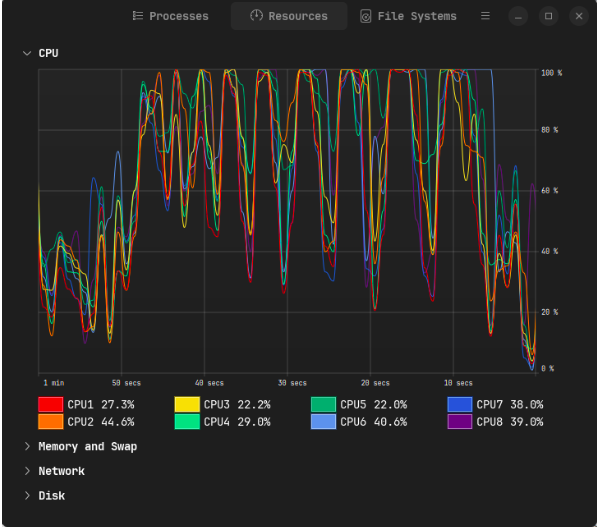

## Ejecución en serie

In [59]:
tiemposSerie = []

for tareas in numeroTareas:
    data = criticas.head(tareas)
    tiempo_inicio = time.time()
    procesamiento(data)
    tiempo_fin = time.time()
    tiemposSerie.append(tiempo_fin - tiempo_inicio)

In [60]:
tiemposSerie

[3.2313826084136963,
 6.072473049163818,
 8.721084833145142,
 11.743313550949097,
 14.410304307937622,
 16.57115912437439,
 19.575806617736816,
 21.81266713142395,
 24.708651781082153,
 26.55943250656128]

### Utilización de procesador:
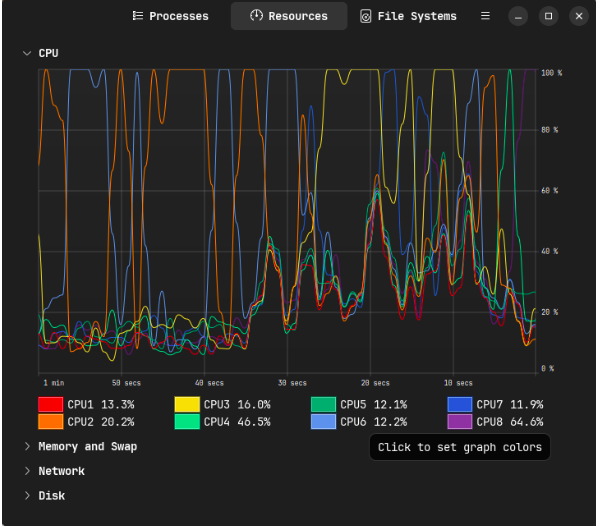

# Resultados

#### Comparación grafica en histograma:

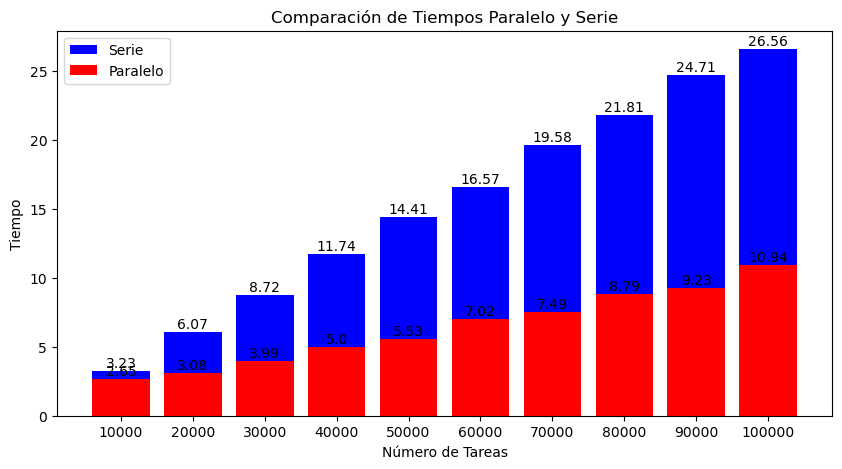

In [81]:
# Convert numeroTareas to a smaller scale for better visualization
x = np.arange(len(numeroTareas))

# Create the stacked bar plot
plt.figure(figsize=(10, 5))

bars1 = plt.bar(x, tiemposSerie, label='Serie', color='b')
bars2 = plt.bar(x, tiemposParalelos, label='Paralelo', color='r')

# Add labels, title, and legend
plt.xlabel('Número de Tareas')
plt.ylabel('Tiempo')
plt.title('Comparación de Tiempos Paralelo y Serie')
plt.xticks(x, numeroTareas)
plt.legend()

for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

# Show the plot
plt.show()

# Conclusion
Podemos concluir en esta practica que la optimización realizada para su ejecución en Paralelo con PSO fué de gran ayuda para recortar tiempos de procesamiento. Esto es vital al querer realizar multiples tareas repetitivas o computacionalmente pesadas. 
Debemos de admitir que la asignación de tareas pudo haberse optimizado aún mas teniendo un rendimiento medible por cada nucleo del procesador, osease, que sea de tiempo constante para repartir las tareas al mejor núcleo o al peor núcleo, dependiendo de su rendimiento.
Sin embargo, la librería de 'multiprocessing' fué de gran ayuda para paralelizar el proceso de manera sencilla en Python.



# Referencias:
- multiprocessing — Process-based parallelism. (s. f.). Python Documentation. Recuperado 21 de octubre de 2024, de https://docs.python.org/3/library/multiprocessing.html